In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import statsmodels.api as sm


In [2]:
chunklist = []
for chunk in pd.read_csv('capstone_data.csv', chunksize = 100000):
    chunklist.append(chunk)

df = pd.concat(chunklist)


In [3]:
df.columns

Index(['pickup', 'trip_time', 'trip_distance', 'avg_speed', 'passenger_count',
       'RatecodeID', 'tempm', 'dewptm', 'hum', 'wspdi', 'wgusti', 'visi',
       'pressurem', 'windchillm', 'heatindexm', 'precipm', 'conds', 'fog',
       'rain', 'snow', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount', 'tip_p',
       'Clear', 'Fog', 'Haze', 'Heavy_Rain', 'Heavy_Snow',
       'Light_Freezing_Rain', 'Light_Rain', 'Light_Snow', 'Mostly_Cloudy',
       'Overcast', 'Partly_Cloudy', 'Rain', 'Scattered_Clouds', 'Snow',
       'Unknown', 'payment_type_1_creditcard', 'payment_type_2_cash',
       'payment_type_3_nocharge', 'payment_type_4_dispute', 'ratecode_1',
       'ratecode_2', 'ratecode_3', 'ratecode_4', 'ratecode_5', 'ratecode_6',
       'ratecode_99', 'month', 'day', 'weekday', 'hour'],
      dtype='object')

### From our previous analysis we know that much of the data is right skewed, so use the log transform to get a more normal distribution

In [4]:
df['trip_time_log'] = np.log(df.trip_time)
df['trip_distance_log'] = np.log(df.trip_distance)
df['fare_amount_log'] = np.log(df.fare_amount+1)
df['avg_speed_log'] = np.log(df.avg_speed)


### Let's also transform all of the date attributes into sin and cos coordinates, so that they become cyclical in nature.

In [5]:
df['hour_sin'] = np.sin(2 * np.pi * (df.hour / 24))
df['hour_cos'] = np.cos(2 * np.pi * (df.hour / 24))

df['weekday_sin'] = np.sin(2 * np.pi * (df.weekday / 7))
df['weekday_cos'] = np.cos(2 * np.pi * (df.weekday / 7))

df['month_sin'] = np.sin(2 * np.pi * (df.month / 12))
df['month_cos'] = np.cos(2 * np.pi * (df.month / 12))

day_sin_list = []
day_cos_list = []
for month in range(1, 13):
    tempdf = df.groupby(df.month).get_group(month)
    day_sin_list.append(np.sin(2 * np.pi * (tempdf.day / max(tempdf.day))))
    day_cos_list.append(np.cos(2 * np.pi * (tempdf.day / max(tempdf.day))))
    
df['days_sin'] = pd.concat(day_sin_list)
df['days_cos'] = pd.concat(day_cos_list)

# Linear Regression Model

In [6]:
X = df[['trip_time_log']]
y = df[['tip_amount']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)


In [7]:
lm = LinearRegression()
lm.fit(X_train, np.log(y_train+1))
y_pred = lm.predict(X_test)

In [8]:
residuals = np.log(y_test.values+1) - y_pred

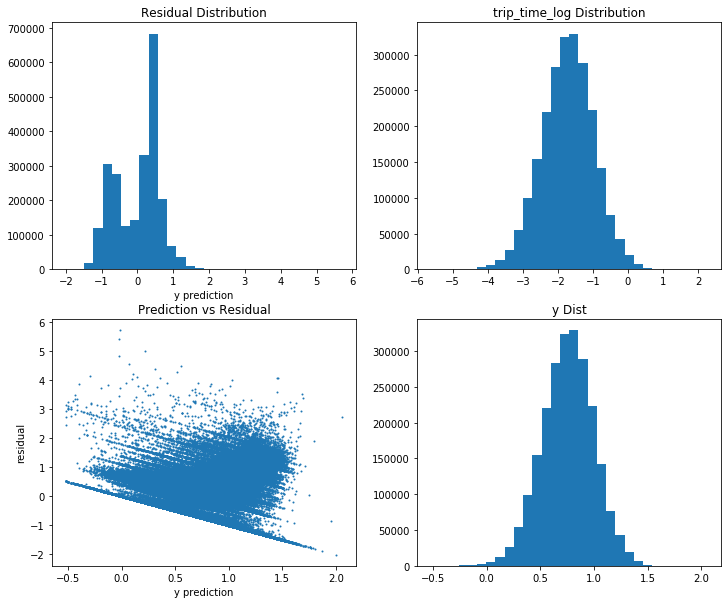

In [9]:
plt.figure(figsize = (12, 10))
plt.subplot(2, 2, 1)
plt.hist(residuals, bins = 30)
plt.title('Residual Distribution')
plt.xlabel('y prediction')

plt.subplot(2, 2, 2)
plt.hist(X_test.values, bins = 30)
plt.title(str(X.columns[0]) + ' Distribution')

plt.subplot(2, 2, 4)
plt.hist(y_pred, bins = 30)
plt.title('y Dist')

plt.subplot(2, 2, 3)
plt.scatter(y_pred, residuals, s = 1)
plt.title('Prediction vs Residual')
plt.xlabel('y prediction')
plt.ylabel('residual')

plt.show()

## Simple Linear Regression Model using the Log of Trip Time, to predict Tip Amount
Let's take our data and exclude samples with a tip amount of 0 to see if it fixed our models heterscedasticity problem

In [10]:
X = df[df.tip_amount > 0][['trip_time_log']]
y = df[df.tip_amount > 0][['tip_amount']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)


In [11]:
lm = LinearRegression()
lm.fit(X_train, np.log(y_train))
y_pred = lm.predict(X_test)

In [12]:
residuals = np.log(y_test.values) - y_pred

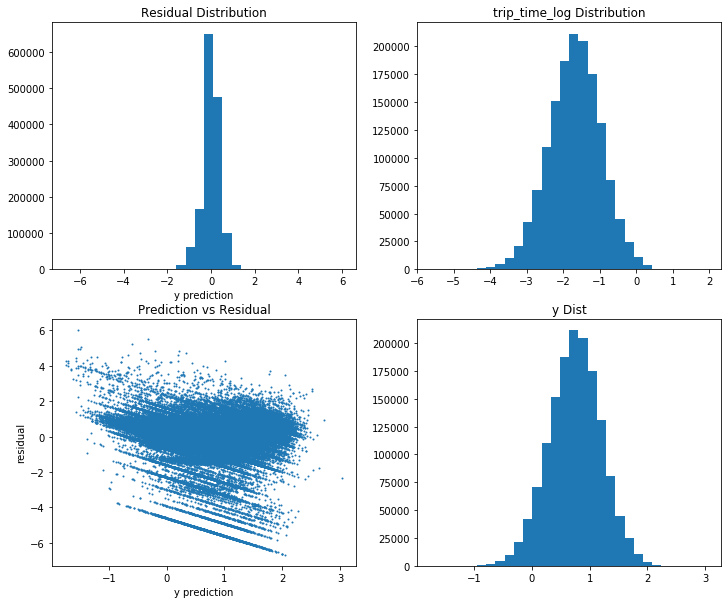

In [13]:
plt.figure(figsize = (12, 10))
plt.subplot(2, 2, 1)
plt.hist(residuals, bins = 30)
plt.title('Residual Distribution')
plt.xlabel('y prediction')

plt.subplot(2, 2, 2)
plt.hist(X_test.values, bins = 30)
plt.title(str(X.columns[0]) + ' Distribution')

plt.subplot(2, 2, 4)
plt.hist(y_pred, bins = 30)
plt.title('y Dist')

plt.subplot(2, 2, 3)
plt.scatter(y_pred, residuals, s = 1)
plt.title('Prediction vs Residual')
plt.xlabel('y prediction')
plt.ylabel('residual')

plt.show()

In [14]:
y_pred_inv = np.exp(y_pred)
sklearn.metrics.r2_score(y_test, y_pred_inv)

0.42664544378616587

The residual distribution appears to be normal.  The distributions of the x and y variables also appear to be normal.  The residuals plot have a line at the bottom that suggests heteroscedasticity, suggesting an invalid linear model. 

## Simple Linear Regression model using Average Speed and Tip Amount

In [15]:
X = df[df.tip_amount > 0][['avg_speed_log']]
y = df[df.tip_amount > 0][['tip_amount']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)


In [16]:
lm = LinearRegression()
lm.fit(X_train, np.log(y_train))
y_pred = lm.predict(X_test)

In [17]:
residuals = np.log(y_test.values) - y_pred

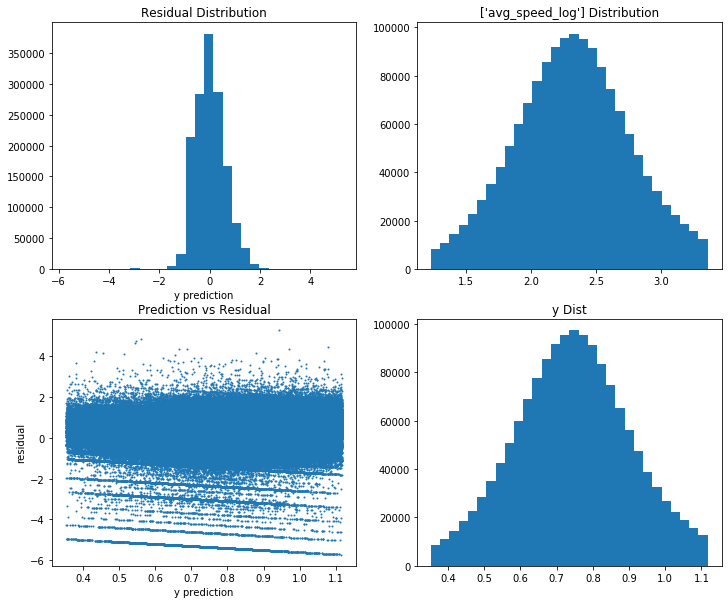

In [18]:
plt.figure(figsize = (12, 10))
plt.subplot(2, 2, 1)
plt.hist(residuals, bins = 30)
plt.title('Residual Distribution')
plt.xlabel('y prediction')

plt.subplot(2, 2, 2)
plt.hist(X_test.values, bins = 30)
plt.title(str(list(X.columns)) + ' Distribution')

plt.subplot(2, 2, 4)
plt.hist(y_pred, bins = 30)
plt.title('y Dist')

plt.subplot(2, 2, 3)
plt.scatter(y_pred, residuals, s = 1)
plt.title('Prediction vs Residual')
plt.xlabel('y prediction')
plt.ylabel('residual')

plt.show()

In [19]:
y_pred_inv = np.exp(y_pred)
sklearn.metrics.r2_score(y_test, y_pred_inv)

0.02054406190979663

The results appear to be similar to the previous model, where the distributions look normal but the residuals plot still suggest heteroscedasticity.  It may be possible that some variable is missing or that it is not possible to use a linear regression model to predict the tip amount.

Let's try a random forest regressor.

# Random Forest Regressor
### Due to using 'mae' being too computational intense, let's use the default 'mse' as our random forest regressor criterion.  This might hinder the model since there appear to be a lot of large outliers present in the tip amounts, which mse will be more sensitive to.  

In [20]:
from sklearn.ensemble import RandomForestRegressor

## Let's try some simple ones first.

### tip amount log ~ avg speed

In [21]:
X = df[df.tip_amount > 0][['avg_speed_log']]
y = df[df.tip_amount > 0].tip_amount

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 7)

In [23]:
rf = RandomForestRegressor(n_estimators = 100)

rf.fit(X_train, np.log(y_train))
y_pred = rf.predict(X_test)

In [24]:
print('MAE ', sklearn.metrics.mean_absolute_error(y_test, np.exp(y_pred)))
print('MSE ', np.sqrt(sklearn.metrics.mean_squared_error(y_test, np.exp(y_pred))))

MAE  0.9561065610011156
MSE  1.9687516819614164


### tip amount log ~ trip time log

In [25]:
X = df[df.tip_amount > 0][['trip_time_log']]
y = df[df.tip_amount > 0].tip_amount

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 7)

In [27]:
rf = RandomForestRegressor(n_estimators = 100)

rf.fit(X_train, np.log(y_train))
y_pred = rf.predict(X_test)

In [28]:
print('MAE ', sklearn.metrics.mean_absolute_error(y_test, np.exp(y_pred)))
print('MSE ', np.sqrt(sklearn.metrics.mean_squared_error(y_test, np.exp(y_pred))))

MAE  0.7622139416741118
MSE  1.6723802057303845


## Use all of the features

In [30]:
X = df[df.tip_amount > 0][['passenger_count', 'tempm',
       'dewptm', 'hum', 'wspdi', 'visi', 'pressurem', 'precipm',
       'fog', 'rain', 'snow', 'Clear', 'Fog',
       'Haze', 'Heavy_Rain', 'Heavy_Snow', 'Light_Freezing_Rain', 'Light_Rain',
       'Light_Snow', 'Mostly_Cloudy', 'Overcast', 'Partly_Cloudy', 'Rain',
       'Scattered_Clouds', 'Snow', 'Unknown',
       'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'ratecode_1', 'ratecode_2', 'ratecode_3',
       'ratecode_4', 'ratecode_5', 'ratecode_6',
       'trip_time_log', 'trip_distance_log', 'fare_amount_log', 'hour_sin',
       'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos',
       'days_sin', 'days_cos', 'avg_speed_log']]

y = df[df.tip_amount > 0].tip_amount

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 7)

In [32]:
%%time
rf = RandomForestRegressor(n_estimators = 100)

rf.fit(X_train, np.log(y_train))
y_pred = rf.predict(X_test)

CPU times: user 2h 8min, sys: 1min 21s, total: 2h 9min 21s
Wall time: 2h 10min 18s


In [33]:
print('MAE ', sklearn.metrics.mean_absolute_error(y_test, np.exp(y_pred)))
print('MSE ', np.sqrt(sklearn.metrics.mean_squared_error(y_test, np.exp(y_pred))))

MAE  0.706130335572921
MSE  1.4717451420045051


The results have imporved but the run time is a bit long.  Let's see if we can improve it by using only the important features.

In [34]:
importance = list(rf.feature_importances_)

In [35]:
feature_list = list(X.columns)

In [36]:
feature_importance = pd.DataFrame({'feature':feature_list, 'importance':[round(x, 2) for x in importance]})
feature_importance.sort_values(by = ['importance'], ascending = False, inplace = True)
feature_importance.reset_index(drop = True, inplace = True)
feature_importance

,feature,importance
0,fare_amount_log,0.57
1,avg_speed_log,0.07
2,trip_time_log,0.07
3,pressurem,0.03
4,trip_distance_log,0.03
5,hum,0.02
6,wspdi,0.02
7,days_cos,0.02
8,days_sin,0.02
9,tempm,0.02


From this we can see that the fare amount is by far the most important feature.

## Let's try again using only the features with importance greater than 0

In [37]:
X = df[df.tip_amount > 0][list(feature_importance[feature_importance.importance != 0].feature)]

y = df[df.tip_amount > 0].tip_amount

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 7)

In [39]:
%%time
rf = RandomForestRegressor(n_estimators = 100)

rf.fit(X_train, np.log(y_train))
y_pred = rf.predict(X_test)

CPU times: user 1h 31min 10s, sys: 1min 11s, total: 1h 32min 22s
Wall time: 1h 33min 12s


In [40]:
mae1 = sklearn.metrics.mean_absolute_error(y_test, np.exp(y_pred))
mse1 = np.sqrt(sklearn.metrics.mean_squared_error(y_test, np.exp(y_pred)))

print('MAE ', mae1)
print('MSE ', mse1)

MAE  0.7116988864975836
MSE  1.4820400547810928


## This time only with features with importance of 0.01 and greater

In [41]:
X = df[df.tip_amount > 0][list(feature_importance[feature_importance.importance > 0.01].feature)]

y = df[df.tip_amount > 0].tip_amount

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 7)

In [43]:
%%time
rf = RandomForestRegressor(n_estimators = 100)

rf.fit(X_train, np.log(y_train))
y_pred = rf.predict(X_test)

CPU times: user 1h 13min 54s, sys: 1min 5s, total: 1h 15min
Wall time: 1h 15min 49s


In [44]:
mae2 = sklearn.metrics.mean_absolute_error(y_test, np.exp(y_pred))
mse2 = np.sqrt(sklearn.metrics.mean_squared_error(y_test, np.exp(y_pred)))

print('MAE ', mae2)
print('MSE ', mse2)

MAE  0.7115118678908683
MSE  1.48047298042072


## This time only with features with importance of 0.07 and greater

In [45]:
X = df[df.tip_amount > 0][list(feature_importance[feature_importance.importance > 0.03].feature)]

y = df[df.tip_amount > 0].tip_amount

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 7)

In [47]:
%%time
rf = RandomForestRegressor(n_estimators = 100)

rf.fit(X_train, np.log(y_train))
y_pred = rf.predict(X_test)

CPU times: user 19min 54s, sys: 22.9 s, total: 20min 17s
Wall time: 20min 35s


In [48]:
mae3 = sklearn.metrics.mean_absolute_error(y_test, np.exp(y_pred))
mse3 = np.sqrt(sklearn.metrics.mean_squared_error(y_test, np.exp(y_pred)))

print('MAE ', mae3)
print('MSE ', mse3)

MAE  0.7164886310868427
MSE  1.5153801759009078


Using only the top 3 important features produce slightly worse results, but have a much shorter run time.

In [49]:
model_list = ['18', '12', 'top 3']
mae_list = [mae1, mae2, mae3]
mse_list = [mse1, mse2, mse3]
time_list = ['1h 33min 12s', '1h 15min 49s', '0h 20min 35s']

from datetime import datetime
from dateutil.parser import parse
time_list = [datetime.strptime(x,'%Hh %Mmin %Ss').time() for x in time_list]
time_list = [(x.hour*60 + x.minute + x.second/60) for x in time_list]

([<matplotlib.axis.XTick at 0x1ccc2c8a90>,
 <a list of 3 Text xticklabel objects>)

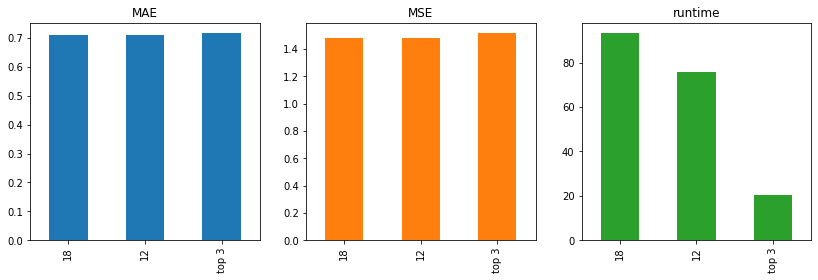

In [50]:
df_compare = pd.DataFrame({'MAE':mae_list, 'MSE':mse_list, 'runtime':time_list})
df_time = pd.DataFrame({'runtime':time_list})

df_compare.plot.bar(subplots = True, layout = (1,3), figsize = (14,4), legend = False)
plt.xticks([0,1,2], (model_list))

Since the MAE and MSE between the models doesn't differ drastically, we should choose the model with the lowest runtime.  

Our random forest regressor using the top 3 most important features is the one we will use.

## Let's fine tune some parameters

In [51]:
f_list = list(feature_importance[feature_importance.importance > .03].feature)

In [52]:
test = df[df.tip_amount > 0].sample(n = 50000)

In [53]:
X = test[test.tip_amount > 0][f_list]
y = test[test.tip_amount > 0].tip_amount

In [54]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()

n_estimators = [10, 50, 100]
max_features = ['auto', 'sqrt', 'log2']
param_grid = {'n_estimators':n_estimators, 'max_features':max_features}

In [55]:
%%time
rf_cv = GridSearchCV(rf, param_grid, cv = 5, scoring = 'neg_mean_absolute_error')

rf_cv.fit(X, np.log(y))

print('best params ', rf_cv.best_params_)


best params  {'max_features': 'sqrt', 'n_estimators': 100}
CPU times: user 3min 17s, sys: 6.91 s, total: 3min 23s
Wall time: 3min 24s


In [56]:
df_cv_results = pd.DataFrame(rf_cv.cv_results_)
df_cv_results.sort_values(by = ['rank_test_score']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,5.654245,0.076847,0.435472,0.009176,sqrt,100,"{'max_features': 'sqrt', 'n_estimators': 100}",-0.306600,-0.306539,-0.311514,-0.306703,-0.308077,-0.307887,0.001901,1
8,5.622867,0.009545,0.430889,0.001216,log2,100,"{'max_features': 'log2', 'n_estimators': 100}",-0.306258,-0.306236,-0.312603,-0.307367,-0.308363,-0.308165,0.002355,2
4,2.824391,0.029137,0.243952,0.021228,sqrt,50,"{'max_features': 'sqrt', 'n_estimators': 50}",-0.307052,-0.307275,-0.313363,-0.307531,-0.308812,-0.308807,0.002359,3
7,2.799848,0.007398,0.226509,0.001326,log2,50,"{'max_features': 'log2', 'n_estimators': 50}",-0.307602,-0.307786,-0.314342,-0.308058,-0.309418,-0.309441,0.002532,4
2,11.772236,0.131006,0.458059,0.005242,auto,100,"{'max_features': 'auto', 'n_estimators': 100}",-0.310097,-0.311085,-0.314045,-0.310486,-0.309793,-0.311101,0.001534,5


Using the negative mean absolute error as our scoring metric, the top 2 parameter choices seem to be 100 n_estimators with either log2 or sqrt for max_features.  Since the times are shorter using log2, we will choose that one.

## Using the parameters that we selected, let's see how it performs.

In [57]:
X = df[df.tip_amount > 0][f_list]
y = df[df.tip_amount > 0].tip_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 7)

In [58]:
%%time

rf = RandomForestRegressor(n_estimators = 100, max_features = 'log2')
rf.fit(X_train, np.log(y_train))

y_pred_tip_amount = rf.predict(X_test)


CPU times: user 11min 3s, sys: 22.9 s, total: 11min 26s
Wall time: 11min 55s


In [59]:
print('MAE ', sklearn.metrics.mean_absolute_error(y_test, np.exp(y_pred_tip_amount)))
print('MSE ', np.sqrt(sklearn.metrics.mean_squared_error(y_test, np.exp(y_pred_tip_amount))))

MAE  0.7123216263215384
MSE  1.5230137753978343


In [60]:
residuals = abs(y_test - np.exp(y_pred_tip_amount))
mape = np.mean(residuals / y_test)
print('Mean Absolute Percentage Error ', round(mape, 3))

mpe = np.mean((y_test.values - np.exp(y_pred_tip_amount))/y_test.values)
print('Mean Percentage Error ', round(mpe,3))


Mean Absolute Percentage Error  0.67
Mean Percentage Error  -0.437


From these error metrics it appears that our model habitually underestimates the tip amount.

Using the chosen parameters, we get a slightly improved model.  The MAE is still slightly higher than when we used all of the available features, but is a bit lower than our previous default model using the top 3 features.  The runtime has also decreased.  

Just for comparisons sake, let's try to predict the tip percentage and see if the results are any different.

## Predict the tip percentage

In [61]:
X = df[df.tip_amount > 0][f_list]
y = df[df.tip_amount > 0].tip_p

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 7)

In [62]:
%%time

rf = RandomForestRegressor(n_estimators = 100, max_features = 'log2')
rf.fit(X_train, np.log(y_train))

y_pred_tip_p = rf.predict(X_test)


CPU times: user 12min 22s, sys: 21.5 s, total: 12min 44s
Wall time: 13min 5s


In [63]:
print('MAE ', sklearn.metrics.mean_absolute_error(y_test, np.exp(y_pred_tip_p)))
print('MSE ', np.sqrt(sklearn.metrics.mean_squared_error(y_test, np.exp(y_pred_tip_p))))

MAE  0.050624423830279694
MSE  1.0233921464194555


In [64]:
residuals = abs(y_test - np.exp(y_pred_tip_p))
mape = np.mean(residuals / y_test)
print('Mean Absolute Percentage Error ', round(mape, 3))

mpe = np.mean((y_test.values - np.exp(y_pred_tip_p))/y_test.values)
print('Mean Percentage Error ', round(mpe,3))


Mean Absolute Percentage Error  0.666
Mean Percentage Error  -0.436


At first glance the lower MAE and MSE look like predicting tip percentages gives us a much better model.  This is misleading though, since the tip amount is predicting dollars and the tip percentage is a percentage.  Looking at the percentage errors gives us better comparison, and it seems that models predicting the tip amount and the tip percentage yield very similar results.  Both have a MAPE of 66.7% and both underpredict by approximately 43.6%.

Since both models yield similar results, let's choose the one where we predict the tip amount in dollars.